In [195]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [196]:
df1 = pd.read_csv('HCPReHoPower2011.csv')
df2 = pd.read_csv('unrestricted.csv',sep=';',thousands ='.',decimal='.')

/var/folders/sm/hmm_qwmj0rjfxblg2m_hsl6h0000gn/T/ipykernel_76563/2815476516.py:2: DtypeWarning: Columns (181,190,396,397,401,403,406,408) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('unrestricted.csv',sep=';',thousands ='.',decimal='.')


In [197]:
# Calculate average across REST1/LR, REST1/RL, REST2/LR, REST2/RL 
grouped = df1.groupby('subject', as_index=False)
averaged_df1 = grouped.mean()

# Select WM_task in 'unresticted.csv'
selected_columns = ['Subject'] + df2.filter(regex = '^WM', axis =1).columns.tolist()
df2_selected = df2[selected_columns]

# Merge them together 
merged_df = pd.merge(averaged_df1, df2_selected, left_on='subject', right_on='Subject')

# Ouput the merged dataframe
merged_df.to_csv('merged_data.csv', index=False)

/var/folders/sm/hmm_qwmj0rjfxblg2m_hsl6h0000gn/T/ipykernel_76563/12421977.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged_df1 = grouped.mean()


In [210]:
# Step 1: Remove missing value in 'unresticted.csv' and Seperate features (X) and targets (y)
selected_targets = merged_df.filter(regex = '^WM', axis =1).columns.tolist()
merged_df_clean = merged_df.dropna(subset= selected_targets)

X = merged_df_clean.iloc[:,1:264]
y = merged_df_clean[selected_targets]

# Step 2: train/test split by 5-fold cross validation
r2_scores = []
k = 5
kf = KFold(n_splits = k)

for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Step 3: Standardize features (important for regression)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

# Step 4: Train a PCA model for targets
    pca = PCA(n_components = 1)
    y_train_pca = pca.fit_transform(y_train)
    y_test_pca = pca.transform(y_test)

# Step 4: Train a Linear Regression Model for Data 
    model = LinearRegression()
    model.fit(X_train, y_train_pca)

# Step 5: Prediction
    y_pred = model.predict(X_test)

# Step 6: Scoring
    r_squared = r2_score(y_test_pca, y_pred)
    r2_scores.append(r_squared)
    
    
    k = k+1
    print("[Fold {0}] R2_score:{1:.3f}".format(k-6,r_squared))


mean_r2 = np.mean(r2_scores)
print("Mean R2:",mean_r2)


[Fold 0] R2_score:-0.555
[Fold 1] R2_score:-0.493
[Fold 2] R2_score:-0.658
[Fold 3] R2_score:-0.594
[Fold 4] R2_score:-0.404
Mean R2: -0.5408581362009246


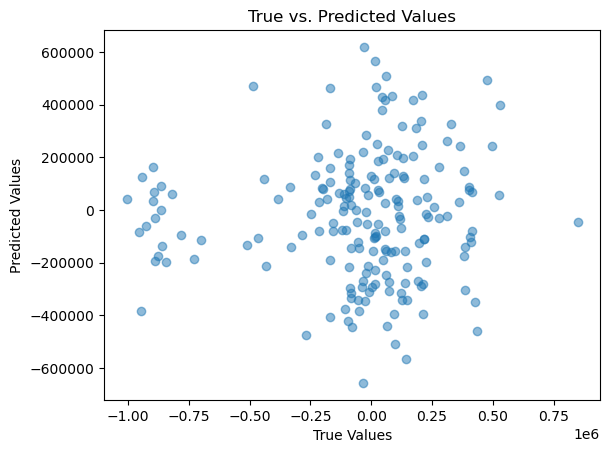

In [ ]:
# Visualization
plt.scatter(y_test_pca, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values")
plt.show()